In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import fmin_cg, minimize
import h5py
c = 2.99792458e8   # m/s

In [2]:
def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return np.sqrt(frac)

def gamma(v):
    return 1. / np.sqrt(1. - (v/c) ** 2)

def dlndopplerdv(v):
    dv = doppler(v)
    return -1. * gamma(v) / (2. * c) * (1. / dv  + dv)

def state(v, xs, xps):
    '''
    outputs: (M, Mp, v, xs, ms, mps, ehs, bees, seas)
    M and Mp are the lengths of data and model wavelength grids
    v is the RV
    xs is the wavelength values of the data grid
    ms is the data index m at which there is an interpolated model value
    mps is the model index m' from which we interpolate to ms
    ehs, bees, and seas go into the coefficients of interpolation
    '''
    # every input must be 1-d
    M = len(xs)
    Mp = len(xps)
    xps_shifted = xps + np.log(doppler(v))
    ms = np.arange(M)
    mps = np.searchsorted(xps_shifted, xs, side='left')
    good = (mps > 0) * (mps < Mp)
    ms = ms[good]
    mps = mps[good]
    ehs = xps_shifted[mps] - xs[ms]
    bees = xs[ms] - xps_shifted[mps - 1]
    seas = ehs + bees
    return (M, Mp, v, xs, ms, mps, ehs, bees, seas)

def Pdot(state, vec):
    # takes state and model flux vector, returns (shifted) model interpolated into data space
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(M)
    result[ms] = vec[mps - 1] * ehs / seas + vec[mps] * bees / seas
    return result

def dotP(state, vec):
    # takes state and data flux vector, returns data interpolated into (shifted) model space
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(Mp)
    result[mps - 1] += vec[ms] * ehs / seas
    result[mps] += vec[ms] * bees / seas
    return result

def dotdPdv(state, vec):
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(Mp)
    foos = vec[ms] / seas * dlndopplerdv(v) # * xs[ms] ??
    result[mps - 1] += foos
    result[mps] -= foos
    return result

def dPdotdv(state, vec):
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(M)
    result[ms] = (vec[mps - 1] - vec[mps]) * dlndopplerdv(v) / seas
    return result

In [3]:
f = h5py.File('../data/hip54287.hdf5', 'r')

N = 75
data = np.copy(f['data'])[:N,:]
data_xs = np.log(np.copy(f['xs']))
ivars = np.copy(f['ivars'])[:N,:]
true_rvs = np.copy(f['true_rvs'])[:N]
bervs = np.copy(f['berv'])[:N] * -1.e3

for i in xrange(len(data)):
    data[i] /= np.median(data[i])
    
data = np.log(data)

In [4]:
def make_template(all_data, rvs, xs, dx):
    """
    `all_data`: `[N, M]` array of pixels
    `rvs`: `[N]` array of RVs
    `xs`: `[M]` array of wavelength values
    `dx`: linear spacing desired for template wavelength grid (A)
    """
    (N,M) = np.shape(all_data)
    all_xs = np.empty_like(all_data)
    for i in range(N):
        all_xs[i,:] = xs - np.log(doppler(rvs[i])) # shift to rest frame
    all_data, all_xs = np.ravel(all_data), np.ravel(all_xs)
    tiny = 10.
    template_xs = np.arange(min(all_xs)-tiny*dx, max(all_xs)+tiny*dx, dx)
    template_ys = np.nan + np.zeros_like(template_xs)
    for i,t in enumerate(template_xs):
        ind = (all_xs >= t-dx/2.) & (all_xs < t+dx/2.)
        if np.sum(ind) > 0:
            template_ys[i] = np.nanmedian(all_data[ind])
    ind_nan = np.isnan(template_ys)
    template_ys.flat[ind_nan] = np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan]) #np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan])
    return template_xs, template_ys

def subtract_template(data_xs, data, model_xs_t, model_ys_t, rvs_t):
    (N,M) = np.shape(data)
    data_sub = np.copy(data)
    for n,v in enumerate(rvs_t):
        s = state(v, data_xs, model_xs_t)
        model_ys_t_shifted = Pdot(s, model_ys_t)
        data_sub[n,:] -= np.ravel(model_ys_t_shifted)
        if n == 0:
            plt.plot(data_xs, data[n,:], color='k')
            plt.plot(data_xs, data_sub[n,:], color='blue')
            plt.plot(data_xs, np.ravel(model_ys_t_shifted), color='red')
    return data_sub

In [5]:
x0_star = -np.copy(bervs)
x0_star -= np.mean(x0_star)
x0_t = np.zeros(N)
model_xs_star, model_ys_star = make_template(data, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
model_xs_t, model_ys_t = make_template(data, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

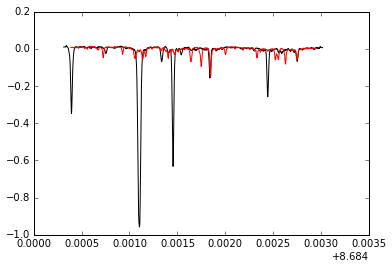

In [6]:
plt.plot(model_xs_star, model_ys_star, color='k')
plt.plot(model_xs_t, model_ys_t, color='red')
#plt.plot(data_xs, data[0,:], color='blue')

In [7]:
stepsize = 0.001
for n in range(75):
    tmp = np.copy(x0_star)
    s = state(tmp[n], data_xs, model_xs_star)
    ddotP1 = dotdPdv(s, data[n,:])
    tmp[n] += stepsize
    s = state(tmp[n], data_xs, model_xs_star)
    dotP0 = dotP(s, data[n,:])
    tmp[n] -= 2. * stepsize
    s = state(tmp[n], data_xs, model_xs_star)
    dotP2 = dotP(s, data[n,:])    
    print ddotP1[1000:1004]
    print (dotP0 - dotP2)[1000:1004]/(2 * stepsize)

[ -2.69414869e-05  -6.94456849e-06   2.71558932e-05   1.91587986e-05]
[ -2.69371981e-05  -6.94346298e-06   2.71515703e-05   1.91557487e-05]
[  1.08835211e-05  -1.58762189e-05  -3.85632344e-05   1.49649364e-05]
[  1.08846866e-05  -1.58779190e-05  -3.85673639e-05   1.49665388e-05]
[ -1.09399898e-05  -1.39728627e-05  -7.35531635e-06  -2.70795854e-06]
[ -1.09382482e-05  -1.39706383e-05  -7.35414546e-06  -2.70752746e-06]
[  1.21707276e-05  -1.82132346e-05   2.36035890e-06   1.03890811e-05]
[  1.21720309e-05  -1.82151849e-05   2.36061165e-06   1.03901935e-05]
[  4.69326451e-06  -7.87548860e-07  -5.49822535e-06  -5.91914654e-06]
[  4.69251741e-06  -7.87423494e-07  -5.49735011e-06  -5.91820430e-06]
[ -1.11401625e-05  -2.86261252e-05  -4.50569516e-06   2.34632785e-05]
[ -1.11383891e-05  -2.86215683e-05  -4.50497792e-06   2.34595435e-05]
[ -6.86534588e-06  -1.55065481e-05  -2.10916303e-05  -2.21527018e-05]
[ -6.86608104e-06  -1.55082086e-05  -2.10938889e-05  -2.21550740e-05]
[  1.97399748e-06  -

In [8]:
stepsize = 0.01
rv_steps = np.arange(0, 10, stepsize)
M = len(data[0,:])
Pdots = np.zeros((len(rv_steps), M))
dPdots = np.zeros((len(rv_steps), M))
for i in xrange(len(rv_steps)):
    drv = rv_steps[i]
    s = state(drv, data_xs, model_xs_star)
    Pdots[i,:] = Pdot(s, model_ys_star)
    dPdots[i,:] = dPdotdv(s, model_ys_star)
    
print (Pdots[-1] - Pdots[0])[1000:1004]
print (np.sum(dPdots*stepsize, axis=0))[1000:1004]

[  1.57089485e-05  -2.40025100e-05   3.77128655e-05   1.44735039e-05]
[  1.57246733e-05  -2.40265368e-05   3.77506165e-05   1.44879921e-05]


In [9]:
def rv_lnprior(rvs):
    return -0.5 * np.mean(rvs)**2/1.**2

def drv_lnprior_dv(rvs):
    return np.zeros_like(rvs) - np.mean(rvs)/1.**2/len(rvs)

def lnlike_star(rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    try:
        N = len(rvs_star)
    except:
        N = 1  
    lnlike = 0.
    dlnlike_dv = np.zeros(N)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dpd_dv = dPdotdv(state_star, model_ys_star)
        dlnlike_dv[n] = np.sum((data[n,:] - pd) * ivars[n,:] * dpd_dv)
    lnpost = lnlike + rv_lnprior(rvs_star)
    dlnpost_dv = dlnlike_dv + drv_lnprior_dv(rvs_star)
    return -1 * lnpost, -1 * dlnpost_dv

def lnlike_t(rvs_t, rvs_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    try:
        N = len(rvs_t)
    except:
        N = 1  
    lnlike = 0.
    dlnlike_dv = np.zeros(N)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dpd_dv = dPdotdv(state_t, model_ys_t)
        dlnlike_dv[n] = np.sum((data[n,:] - pd) * ivars[n,:] * dpd_dv)
    lnpost = lnlike + rv_lnprior(rvs_t)
    dlnpost_dv = dlnlike_dv + drv_lnprior_dv(rvs_t)
    return -1 * lnpost, -1 * dlnpost_dv



In [67]:
def model_ys_lnprior(w):
    return -0.5 * np.sum(w**2)/100.**2


def dmodel_ys_lnprior_dw(w):
    return -1.*w / 100.**2


def dlnlike_star_dw_star(model_ys_star, rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t):
    try:
        N = len(rvs_star)
    except:
        N = 1  
    lnlike = 0.
    Mp = len(model_xs_star)
    dlnlike_dw = np.zeros(Mp)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        dp_star = dotP(state_star, (data[n,:] - pd)*ivars[n,:]) 
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dlnlike_dw += dp_star
    lnprior = model_ys_lnprior(model_ys_star)
    dlnprior = dmodel_ys_lnprior_dw(model_ys_star)
    return -lnlike - lnprior, -dlnlike_dw - dlnprior

def dlnlike_t_dw_t(model_ys_t, rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t):
    try:
        N = len(rvs_t)
    except:
        N = 1  
    lnlike = 0.
    Mp = len(model_xs_t)
    dlnlike_dw = np.zeros(Mp)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        dp_t = dotP(state_t, (data[n,:] - pd)*ivars[n,:]) 
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dlnlike_dw += dp_t
    lnprior = model_ys_lnprior(model_ys_t)
    dlnprior = dmodel_ys_lnprior_dw(model_ys_t)
    return -lnlike - lnprior, -dlnlike_dw - dlnprior

In [64]:
print dlnlike_star_dw_star(model_ys_star, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)

stepsize = 0.001
lnlike1, dlnlike_dv1 = dlnlike_star_dw_star(model_ys_star, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
for n in range(75):
    tmp = np.copy(model_ys_star)
    tmp[n] += stepsize
    lnlike0, dlnlike_dv0 = dlnlike_star_dw_star(tmp, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    tmp[n] -= 2. * stepsize
    lnlike2, dlnlike_dv2 = dlnlike_star_dw_star(tmp, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    print dlnlike_dv1[n]
    print (lnlike0 - lnlike2)/(2 * stepsize)
    


(368038.68026611034, array([  3.90215654e-08,   3.90215654e-08,   3.90215654e-08, ...,
         8.32576703e-07,   8.32576703e-07,   8.32576703e-07]))
3.90215653639e-08
5.82076609135e-08
3.90215653639e-08
5.82076609135e-08
3.90215653639e-08
5.82076609135e-08
3.90215653639e-08
5.82076609135e-08
3.90215653639e-08
5.82076609135e-08
3.90215653639e-08
5.82076609135e-08
3.90215653639e-08
5.82076609135e-08
3.90215653639e-08
5.82076609135e-08
3.90215653639e-08
5.82076609135e-08
3.90215653639e-08
5.82076609135e-08
-1378.99128758
-1378.99128758
-2617.9372738
-2617.93727381
-2051.85458744
-2051.85458745
-2451.43838762
-2451.43838759
-2569.27554283
-2569.2755428
-2565.45136065
-2565.45136066
-2715.95464497
-2715.95464493
-2175.77731247
-2175.77731248
-1997.83626165
-1997.83626164
-3330.34430828
-3330.34430831
-3973.41923964
-3973.41923969
-3858.34230452
-3858.34230448
-3590.80468603
-3590.80468604
-3608.85898644
-3608.85898647
-3317.81923
-3317.81923
-3713.06454394
-3713.0645439
-4101.82702886
-410

In [68]:
print dlnlike_t_dw_t(model_ys_t, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)

stepsize = 0.001
lnlike1, dlnlike_dv1 = dlnlike_t_dw_t(model_ys_t, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
for n in range(75):
    tmp = np.copy(model_ys_t)
    tmp[n] += stepsize
    lnlike0, dlnlike_dv0 = dlnlike_t_dw_t(tmp, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    tmp[n] -= 2. * stepsize
    lnlike2, dlnlike_dv2 = dlnlike_t_dw_t(tmp, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    print dlnlike_dv1[n]
    print (lnlike0 - lnlike2)/(2 * stepsize)

(368038.67932978622, array([  2.59582942e-07,   2.59582942e-07,   2.59582942e-07, ...,
        -1.16316011e-06,  -1.16316011e-06,  -1.16316011e-06]))
2.59582941873e-07
2.61934474111e-07
2.59582941873e-07
2.61934474111e-07
2.59582941873e-07
2.61934474111e-07
2.59582941873e-07
2.61934474111e-07
2.59582941873e-07
2.61934474111e-07
2.59582941873e-07
2.61934474111e-07
2.59582941873e-07
2.61934474111e-07
2.59582941873e-07
2.61934474111e-07
2.59582941873e-07
2.61934474111e-07
2.59582941873e-07
2.61934474111e-07
-11575.4633122
-11575.4633121
-17594.0702741
-17594.070274
-17837.8665232
-17837.8665232
-18554.115333
-18554.1153329
-19426.4165378
-19426.4165378
-17913.3386473
-17913.3386474
-17254.5050379
-17254.5050379
-17642.082678
-17642.0826781
-17567.9233491
-17567.9233491
-16962.2344512
-16962.2344513
-15731.4061204
-15731.4061204
-15788.3841791
-15788.3841791
-16896.661413
-16896.6614129
-17052.5213749
-17052.5213749
-15823.1878015
-15823.1878015
-15865.1653017
-15865.1653017
-17728.0812906

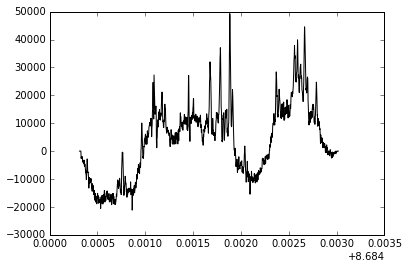

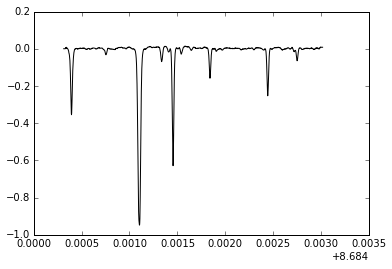

In [42]:
dw = dlnlike_star_dw_star(model_ys_star, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)[1]

plt.plot(model_xs_star, dw, 'k')
plt.show()
plt.plot(model_xs_star, model_ys_star, 'k')

In [56]:
w = np.copy(model_ys_star + np.random.normal(0, 0.01, len(model_ys_star)))
for i in range(50):
    lnlike, dlnlike_dw = dlnlike_star_dw_star(w, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    w -= 5e-7 * dlnlike_dw 
    print lnlike
    


492349.45072
318705.260105
307593.995908
305505.537491
304845.444072
304584.732112
304464.077543
304400.022383
304361.973673
304337.393984
304320.54628
304308.512013
304299.660219
304293.00661
304287.920739
304283.980278
304280.892584
304278.449536
304276.500058
304274.932632
304273.663784
304272.630273
304271.783683
304271.086597
304270.509853
304270.030549
304269.630568
304269.295489
304269.013758
304268.77607
304268.57489
304268.404084
304268.258641
304268.134443
304268.028098
304267.936797
304267.858209
304267.79039
304267.731716
304267.680825
304267.636573
304267.597993
304267.564272
304267.534717
304267.508743
304267.48585
304267.465614
304267.447672
304267.431713
304267.41747


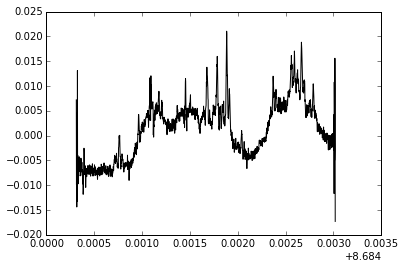

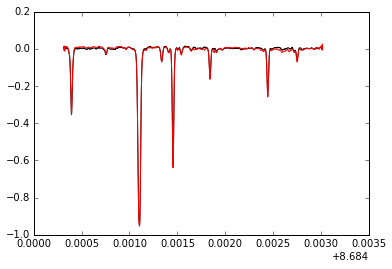

In [57]:
plt.plot(model_xs_star, model_ys_star-w, 'k')
plt.show()

plt.plot(model_xs_star, model_ys_star, 'k')
plt.plot(model_xs_star, w, 'r')

In [73]:
def improve_telluric_model(model_ys_t, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t):
    w = np.copy(model_ys_t)
    for i in range(50):
        lnlike, dlnlike_dw = dlnlike_t_dw_t(w, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
        w -= 5e-7 * dlnlike_dw    
    return w

def improve_star_model(model_ys_star, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t):
    w = np.copy(model_ys_star + np.random.normal(0, 0.01, len(model_ys_star)))
    for i in range(50):
        lnlike, dlnlike_dw = dlnlike_star_dw_star(w, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
        w -= 5e-7 * dlnlike_dw 
    return w

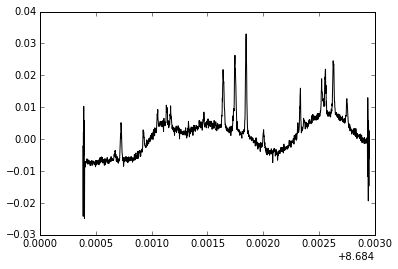

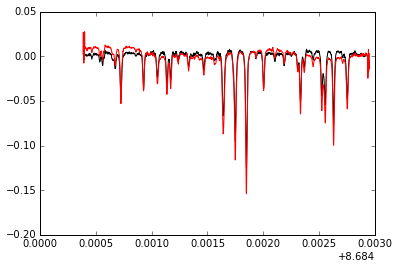

In [71]:
plt.plot(model_xs_t, model_ys_t-w, 'k')
plt.show()

plt.plot(model_xs_t, model_ys_t, 'k')
plt.plot(model_xs_t, w, 'r')

In [10]:
print lnlike_star(x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
print lnlike_star(true_rvs, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)

(443867.6785671917, array([-0.87910805, -0.1619633 , -4.51401912, -4.71766669, -0.90009856,
       -0.19824533, -1.20954629,  0.02018255, -0.99938244,  0.41831268,
        0.77227716,  0.94737996,  0.91713539,  0.35727079,  0.32425574,
       -0.86087292, -0.77795605, -0.76184418,  0.25432231, -0.11924608,
       -0.15891915,  0.55794609, -0.147008  ,  0.9849068 ,  1.19365293,
       -0.57464147, -0.0171348 ,  0.15305185,  0.09707713,  0.06284911,
       -0.34747223,  0.61407795, -0.53636073,  0.72579548, -2.00879154,
       -2.69445675,  0.60371669,  0.58900744,  0.71425305,  0.90561099,
       -0.55373991, -0.2243429 ,  0.45904055,  0.05294681,  1.41593872,
        0.0782868 , -0.67893733,  0.20556393,  0.4219801 ,  0.736875  ,
        0.42665224,  0.82496428,  0.02509037,  0.43471543, -2.01852413,
       -2.29408248, -2.42152862, -1.13682841, -0.66191128,  0.35960118,
        0.32638424,  0.61371447,  0.00694899,  0.51962859,  0.41320101,
       -0.02657668, -1.64806063, -1.83825373

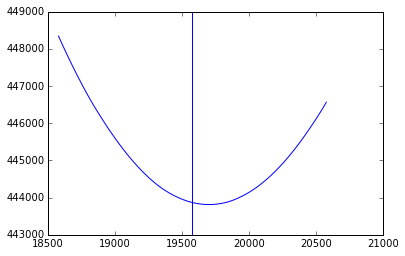

In [11]:
test_rvs = np.linspace(-1.e3+x0_star[0], 1.e3+x0_star[0], 100)
chisq = np.zeros_like(test_rvs)
for i,v in enumerate(test_rvs):
    tmp = np.copy(x0_star)
    tmp[0] = v
    lnlike0, dlnlike_dv0 = lnlike_star(tmp, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    chisq[i] = lnlike0
    
plt.plot(test_rvs, chisq)
plt.axvline(x0_star[0])

In [12]:
stepsize = 0.001
lnlike1, dlnlike_dv1 = lnlike_star(x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
for n in range(75):
    tmp = np.copy(x0_star)
    tmp[n] += stepsize
    lnlike0, dlnlike_dv0 = lnlike_star(tmp, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    tmp[n] -= 2. * stepsize
    lnlike2, dlnlike_dv2 = lnlike_star(tmp, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    print dlnlike_dv1[n]
    print (lnlike0 - lnlike2)/(2 * stepsize)

-0.87910804999
-0.87896810146
-0.161963302813
-0.16198065714
-4.51401912282
-4.51330054784
-4.71766669299
-4.71817186917
-0.900098560144
-0.899955281056
-0.19824532872
-0.198213761905
-1.20954629335
-1.20967582916
0.0201825500319
0.0201847287826
-0.999382436614
-0.999489449896
0.418312679852
0.41835749289
0.772277155417
0.772359868279
0.947379963951
0.947229156736
0.917135392113
0.917233614018
0.357270792443
0.35730903619
0.324255736322
0.324290449498
-0.86087291639
-0.860735890456
-0.777956051149
-0.778039364377
-0.761844179345
-0.76192576671
0.254322314127
0.254349550232
-0.119246078296
-0.119258853374
-0.158919146041
-0.15889381757
0.55794608888
0.558005820494
-0.147008003934
-0.147023733007
0.984906800961
0.9850122442
1.19365292585
1.19346292922
-0.574641469373
-0.574703008169
-0.017134798029
-0.0171366264112
0.15305184597
0.153068220243
0.0970771299176
0.0970616820268
0.0628491090692
0.0628503912594
-0.347472232019
-0.347509427229
0.614077947524
0.614143704297
-0.536360726272
-0.5

In [13]:
stepsize = 0.001
lnlike1, dlnlike_dv1 = lnlike_t(x0_t, x0_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
for n in range(75):
    tmp = np.copy(x0_t)
    tmp[n] += stepsize
    lnlike0, dlnlike_dv0 = lnlike_t(tmp, x0_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    tmp[n] -= 2. * stepsize
    lnlike2, dlnlike_dv2 = lnlike_t(tmp, x0_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    print dlnlike_dv1[n]
    print (lnlike0 - lnlike2)/(2 * stepsize)

-0.0176042673085
-0.017605809262
-0.0127509277187
-0.0127514067572
0.23001198461
0.230032339459
0.0986525211528
0.098653632449
-0.149211784488
-0.149237719597
-0.0481950948015
-0.048200978199
0.158361759093
0.158371723955
0.191652325441
0.191667029867
0.0885830974417
0.0885874324013
0.079882587305
0.0798908004072
-0.0834039051116
-0.0834140519146
0.0850687635977
0.0850785581861
-0.152208797979
-0.152226071805
-0.0820953321095
-0.0821056892164
-0.0602758991428
-0.0602833752055
-0.192269536399
-0.192304782104
-0.11751967885
-0.117534218589
0.0205253986043
0.0205193355214
0.194453370224
0.194469816051
0.40023603699
0.400266057113
0.0609940341352
0.0609985436313
-0.0162487916556
-0.0162526266649
-0.123480332959
-0.123500736663
-0.0685126102419
-0.0685202830937
-0.115218496302
-0.115237402497
-0.0109103279118
-0.0109147222247
0.112929442842
0.112940208055
0.140308106008
0.140323012602
0.217414824879
0.217438937398
0.115863684865
0.115868664579
0.148558227063
0.148570921738
0.184976049233
0.

In [14]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
print np.std(soln_star + true_rvs)

Optimization terminated successfully.
         Current function value: 442225.913796
         Iterations: 36
         Function evaluations: 41
         Gradient evaluations: 41
39.3266149393


/Users/ozymandias1/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


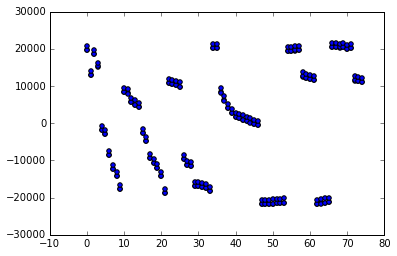

In [15]:
plt.scatter(np.arange(N), x0_star)
plt.scatter(np.arange(N), soln_star)
plt.scatter(np.arange(N), -true_rvs)
plt.show()

In [16]:
print soln_star - x0_star

[ 114.47111633   11.23517052   87.53063852   87.20417449   23.36884
    8.50667176   22.2674664    -4.54865369   31.67382252  -33.51331379
  -33.70280716  -68.69551094  -30.54048049  -30.7621751   -32.37179782
   15.1090745    31.23012578   22.99382097   -7.80296457    0.57638004
    4.01138332  -16.78663845    1.90822936  -46.18849278  -35.66443189
   16.44846768   -3.99245532  -12.64026049   -8.75797355   -3.34935595
   10.12350381  -16.40567363   12.02375123  -37.2687935    76.76821946
   73.6813744   -29.87725375  -40.79167722  -37.01960293  -27.25461834
   17.95269618    6.40701908  -17.64347604   -6.47938961  -60.83930442
   -5.51913569   17.38826873  -14.91075906  -17.06027592  -22.06842479
  -17.77541763  -22.31486666   -7.47667157  -18.8672656    78.32561778
   86.90159755   82.59672897   46.96801355   24.58454826  -21.11464458
  -20.4846025   -33.92670311  -11.1240641   -33.52004391  -14.27831722
   -3.45270177   58.23700388   89.00413786   61.67138842   62.88393987
   33.863

In [17]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']

x0_star = soln_star
x0_t = soln_t
print np.std(x0_star + true_rvs)
print np.std(x0_t)

Optimization terminated successfully.
         Current function value: 442225.913796
         Iterations: 36
         Function evaluations: 41
         Gradient evaluations: 41
         Current function value: 441862.971158
         Iterations: 184
         Function evaluations: 281
         Gradient evaluations: 277
39.3266149393
70.4475246451


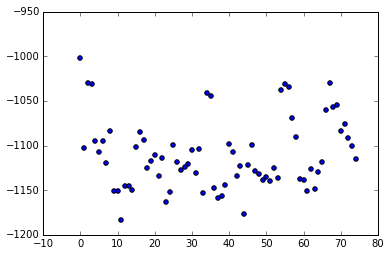

In [18]:
plt.scatter(np.arange(N), soln_star + true_rvs)

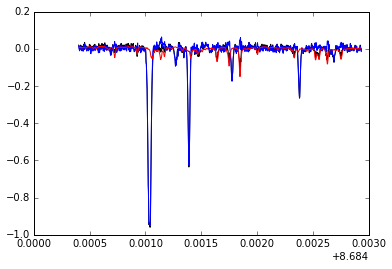

In [19]:
data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, x0_t)

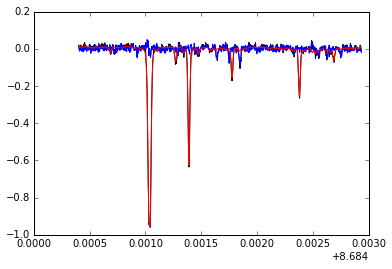

In [20]:
data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, x0_star)

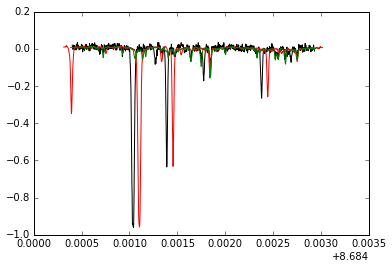

In [21]:
plt.plot(data_xs, data[0,:], color='black')
plt.plot(model_xs_star, model_ys_star, color='red')
plt.plot(model_xs_t, model_ys_t, color='green')

In [22]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']


print np.std(soln_star + true_rvs)
print np.std(soln_t)

Optimization terminated successfully.
         Current function value: 441882.387801
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
         Current function value: 441862.242097
         Iterations: 156
         Function evaluations: 328
         Gradient evaluations: 315
39.357544985
70.506382236


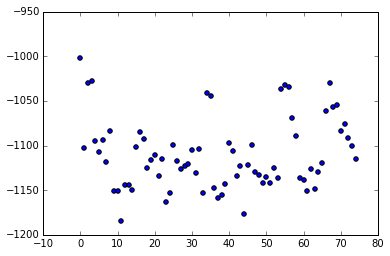

In [23]:
plt.scatter(np.arange(N), soln_star + true_rvs)

Optimization terminated successfully.
         Current function value: 368226.388170
         Iterations: 29
         Function evaluations: 32
         Gradient evaluations: 32
         Current function value: 287337.446714
         Iterations: 155
         Function evaluations: 257
         Gradient evaluations: 250
iter 0: star std = 21.26, telluric std = 95.51


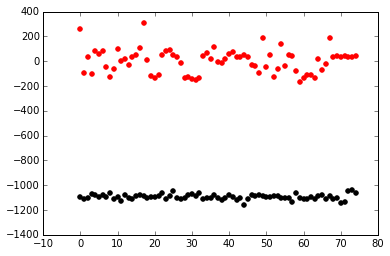

Optimization terminated successfully.
         Current function value: 285498.243616
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
         Current function value: 284499.904162
         Iterations: 26
         Function evaluations: 115
         Gradient evaluations: 110
iter 1: star std = 19.76, telluric std = 100.88


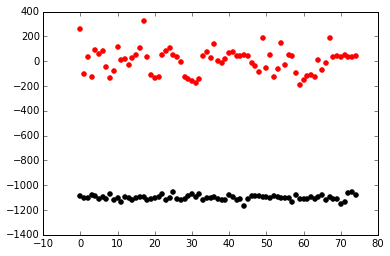

         Current function value: 284046.107066
         Iterations: 56
         Function evaluations: 139
         Gradient evaluations: 128
         Current function value: 283566.030479
         Iterations: 138
         Function evaluations: 245
         Gradient evaluations: 242
iter 2: star std = 19.72, telluric std = 107.78


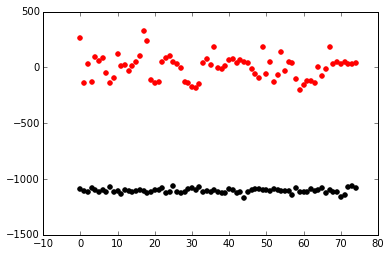

Optimization terminated successfully.
         Current function value: 283312.605717
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
         Current function value: 283054.794250
         Iterations: 33
         Function evaluations: 115
         Gradient evaluations: 109
iter 3: star std = 19.77, telluric std = 108.47


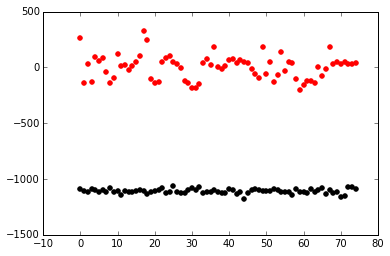

Optimization terminated successfully.
         Current function value: 282888.702977
         Iterations: 20
         Function evaluations: 27
         Gradient evaluations: 27
         Current function value: 282723.499724
         Iterations: 24
         Function evaluations: 107
         Gradient evaluations: 102
iter 4: star std = 19.87, telluric std = 108.57


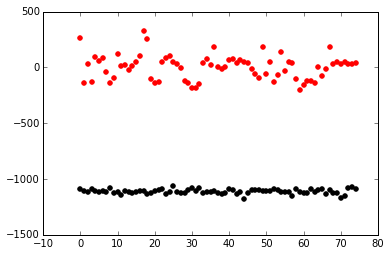

In [74]:
for n in range(5):
    soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    
    model_ys_t = improve_telluric_model(model_ys_t, soln_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    model_ys_star = improve_star_model(model_ys_star, soln_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)

    soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    
    model_ys_t = improve_telluric_model(model_ys_t, soln_star, soln_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    model_ys_star = improve_star_model(model_ys_star, soln_star, soln_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    
    x0_star = soln_star
    x0_t = soln_t

    print "iter {0}: star std = {1:.2f}, telluric std = {2:.2f}".format(n, np.std(soln_star + true_rvs), np.std(soln_t))
    plt.scatter(np.arange(N), soln_star + true_rvs, color='k')
    plt.scatter(np.arange(N), soln_t, color='red')
    plt.show()


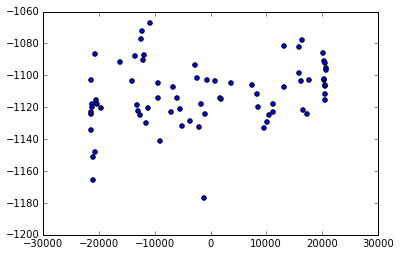

In [79]:
plt.scatter(bervs, soln_star+true_rvs)

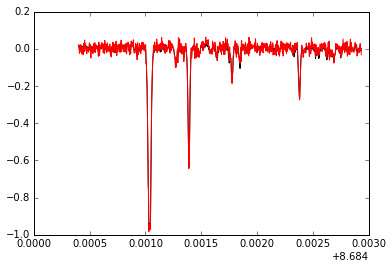

In [25]:
plt.plot(data_xs, data[0,:], color='k')
plt.plot(data_xs, data_star[0,:] + data_t[0,:], color='red')

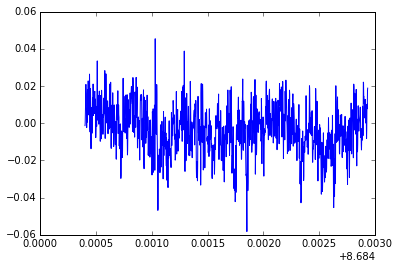

In [26]:
plt.plot(data_xs, data[0,:] - data_star[0,:] - data_t[0,:])

(array([   1.,   11.,   58.,  143.,  360.,  493.,  312.,  112.,    8.,    2.]),
 array([-0.05823505, -0.04787159, -0.03750813, -0.02714467, -0.0167812 ,
        -0.00641774,  0.00394572,  0.01430919,  0.02467265,  0.03503611,
         0.04539957]),
 <a list of 10 Patch objects>)

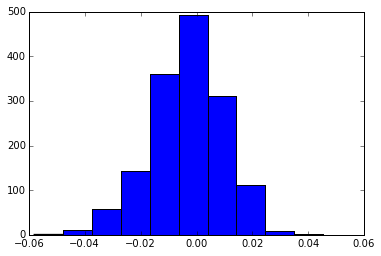

In [27]:
plt.hist(data[0,:] - data_star[0,:] - data_t[0,:])